In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # visualize loop progress
from lightweight_charts import Chart
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

# excel interaction
import xlwings as xw # dynamic Excel interaction


In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm  # Visualize loop progress
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import yfinance as yf
import vectorbt as vbt
import datetime as dt
from datetime import timedelta as td
import datetime

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
vbt.settings.set_theme('dark')
# vbt.settings.plotting.aut_rangebreaks = True

In [4]:
import requests
import json

In [5]:
from dotenv import load_dotenv
load_dotenv()

True

| Gap-Up Screener |
|--|
TradingView Data (import)

In [6]:
# today's date string for file naming automation
# today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
# today_date_str = '_2024-06-11.csv' # this is a near perfect outcome example replay day
today_date_str = '_2024-06-21.csv'


print(today_date_str)

_2024-06-21.csv


In [7]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

863 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Industry,Sector,Exchange,Index,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Relative Volume at Time,Relative Volume 1 day,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 week,Relative Volume 1 month,Highest high 1 month,Highest high 1 month - Currency,Highest high 3 months,Highest high 3 months - Currency,Highest high 6 months,Highest high 6 months - Currency,Highest high 52 weeks,Highest high 52 weeks - Currency,Highest high All Time,Highest high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",International Securities Identification Number,Relative Volume 1 day.1,Recent earnings date,Upcoming earnings date,Analyst Rating,Target price 1 year,Target price 1 year - Currency,Technical Rating 5 minutes
0,MSFT,Microsoft Corporation,Packaged Software,Technology Services,NASDAQ,"S&P 500, NASDAQ 100, Dow Jones Industrial Average, NASDAQ Composite, S&P 500 Information Technology, S&P 100, Russell 3000, Dow Jones Composite Average, NASDAQ-100 Technology Sector, Russell 1000, NASDAQ Computer, S&P 500 ESG, NYSE Arca Major Market",3.312579e+12,USD,445.70,USD,444.60,USD,1.0000,USD,0.224366,-0.246803,7.322780e+09,19877378,57779912.0,65483,1.667251e+07,1.778746e+07,1.969841e+07,1.192014,1.291657,1.521198,444.500000,38.618168,1.323022,1.213250,1.004893,1.058739,0.892526,3.449809,4.019505,3.397241,2.137297,0.980113,0.517859,0.761237,0.623959,0.451153,450.94,USD,450.94,USD,450.94,USD,450.94,USD,450.94,USD,446.04,USD,446.06,USD,446.06,USD,446.06,USD,446.06,USD,446.06,USD,446.53,USD,450.94,USD,450.94,USD,9.588914e+05,USD,445.72382,445.712387,445.08096,444.755062,446.153213,445.205780,444.258347,445.681918,444.755165,443.828412,US5949181045,1.213250,2024-04-25,2024-07-23,Strong buy,486.316600,USD,Buy
1,AAPL,Apple Inc.,Telecommunications Equipment,Electronic Technology,NASDAQ,"S&P 500, NASDAQ 100, Dow Jones Industrial Average, NASDAQ Composite, S&P 500 Information Technology, S&P 100, Russell 3000, Dow Jones Composite Average, NASDAQ-100 Technology Sector, Russell 1000, NASDAQ Computer, S&P 500 ESG",3.215250e+12,USD,209.68,USD,209.47,USD,1.9200,USD,0.915681,-0.100153,1.532013e+10,86171559,259844005.0,595059,9.898770e+07,6.714861e+07,6.554542e+07,2.604740,2.125889,2.174615,210.923333,32.605586,0.823380,0.899624,1.178859,1.200235,1.250108,2.326535,3.423481,3.728077,2.130770,1.050372,0.532658,0.584009,0.805600,0.923423,220.20,USD,220.20,USD,220.20,USD,220.20,USD,220.20,USD,209.73,USD,209.73,USD,209.75,USD,209.75,USD,209.75,USD,210.61,USD,214.24,USD,218.95,USD,220.20,USD,2.380652e+06,USD,209.49100,209.417487,209.40700,209.567592,209.646884,209.355245,209.063606,210.210195,209.676430,209.142665,US0

In [8]:
#### CREATE MARKET CAP CATEGORIES ####
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans - 200 billion and above
        (df['Market capitalization'] >= 200000000000),
        # Large Cap - 10 billion to 200 billion
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),
        # Midlers - 2 billion to 10 billion
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),
        # Small Cap - 300 million to 2 billion
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000), 
        # Micro Cap - 50 million to 300 million
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),
        # Shrimp - 50 million and below
        (df['Market capitalization'] <= 50000000)
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df

In [9]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)
print(len(trading_view_raw_df.index))

863


In [10]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [11]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 863 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Shrimp,225,26.071842
1,Small caps,180,20.857474
2,Large caps,157,18.192352
3,Micro caps,150,17.381228
4,Midlers,129,14.947856
5,Titans,18,2.085747
6,Undefined,4,0.463499


In [12]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

231 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Industry,Sector,Exchange,Index,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Relative Volume at Time,Relative Volume 1 day,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 week,Relative Volume 1 month,Highest high 1 month,Highest high 1 month - Currency,Highest high 3 months,Highest high 3 months - Currency,Highest high 6 months,Highest high 6 months - Currency,Highest high 52 weeks,Highest high 52 weeks - Currency,Highest high All Time,Highest high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",International Securities Identification Number,Relative Volume 1 day.1,Recent earnings date,Upcoming earnings date,Analyst Rating,Target price 1 year,Target price 1 year - Currency,Technical Rating 5 minutes,marketCapType
77,KDP,Keurig Dr Pepper Inc.,Food: Specialty/Candy,Consumer Non-Durables,NASDAQ,"S&P 500, NASDAQ 100, NASDAQ Composite, S&P 500 Consumer Staples, Russell 3000, Russell 1000, NASDAQ Industrials, S&P 500 ESG",4.637419e+10,USD,34.21,USD,34.39,USD,0.1200,USD,0.350775,0.526162,1.054768e+09,7070331,20679059.0,5070,6411419.4,6.621697e+06,9.809473e+06,1.708898,1.388114,1.429191,34.223333,22.113769,0.995055,1.083552,0.254824,0.423461,0.618441,3.093561,7.294467,9.014082,6.313502,3.225988,1.746809,1.219622,0.579432,0.460279,35.0000,USD,35.00,USD,35.000,USD,35.000,USD,41.31,USD,34.2400,USD,34.240,USD,34.240,USD,34.240,USD,34.240,USD,34.27,USD,34.520,USD,34.77,USD,35.00,USD,5.271886e+05,USD,34.211,34.208125,34.18100,34.151946,34.232248,34.17725,34.122252,34.235635,34.115265,33.994895,US49271V1008,1.083552,2024-04-25,2024-07-25,Buy,37.295789,USD,Buy,Large caps
384,DX,"Dynex Capital, Inc.",Real Estate Investment Trusts,Finance,NYSE,"Russell 2000, Russell 3000, Mini-Russell 2000",8.979874e+08,USD,12.02,USD,12.01,USD,0.0100,USD,0.083195,-0.083195,7.339705e+07,1802378,3857838.0,3570,2561640.4,1.446993e+06,1.331637e+06,1.258389,1.145858,1.406550,12.003333,10.308748,0.787482,0.729228,1.705653,1.041146,1.323384,14.159583,3.708299,5.939415,5.631450,3.067400,1.868299,1.476727,0.550328,1.224503,12.4800,USD,12.65,USD,13.125,USD,13.555,USD,195.00,USD,12.0400,USD,12.060,USD,12.060,USD,12.060,USD,12.060,USD,12.07,USD,12.070,USD,12.07,USD,12.48,USD,6.027318e+06,USD,12.030,12.031250,12.03800,12.039615,12.054522,12.03875,12.022978,12.064580,12.039500,12.014420,US26817Q8868,0.729228,2024-04-22,2024-07-22,Buy,13.625000,USD,Sell,Small caps
106,VICI,VICI Properties Inc.,Real Estate Investment Trusts,Finance,NYSE,"S&P 500, S&P 500 Real Estate, Russell 3000, Russell 1000",2.929254e+10,USD,28.08,USD,28.20,USD,0.0200,USD,0.071225,0.427350,1.039654e+09,6255976,21594028.0,836,5826141.6,6.316382e+06,6.33

In [13]:
print(len(trading_view_raw_df))

863


In [14]:
# drop undefined
tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

print(tv_df.shape)

(231, 91)


In [15]:
market_info_df = tv_df['marketCapType'].value_counts().reset_index()
market_info_df.columns = ['marketCapType', 'count']  # Rename columns for clarity

# calculate percentage for each market cap type and add it to the DataFrame
market_info_df['percentage'] = (market_info_df['count'] / market_info_df['count'].sum()) * 100

print(market_info_df.shape)
market_info_df

(6, 3)


,marketCapType,count,percentage
0,Large caps,114,49.350649
1,Midlers,55,23.809524
2,Small caps,41,17.748918
3,Titans,14,6.060606
4,Micro caps,6,2.597403
5,Shrimp,1,0.432900


In [16]:
# need to add error handling for when zero (0) return (4/4/24)
# zero again 5/24/24
# - not so much error handling but want to see if we need to adjust the criteria in general
# - need to put this theory and algo through more paper trading and adjust as needed
# think about adding other staples to dataframe
# or you create a separate investments_long_df or similar for those, i.e., TSLA, PLTR, SOFI etc...

| FILTER CRITERIA CONFIG |
|-|
| TradingView (raw data) | 

things to add;
* Pre-Market Volume: Adding a minimum pre-market volume threshold can help filter out stocks that might have large percentage changes but low trading volumes, which can lead to unreliable price movements and high slippage.
Example: A minimum of 50,000 shares traded in the pre-market for all categories.

* overall market sentiment and filter tightener (macro)

In [17]:
#### CRITERIA CONFIG DICTIONARY ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # 1 billion shares
        "relative_volume_threshold": 1.2,  # More inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # 0.1%
        "pre_market_vwap_drawdown_threshold": 0.003,  # 0.3% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # 200 million shares
        "relative_volume_threshold": 1.3,  # More inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # 0.5%
        "pre_market_vwap_drawdown_threshold": 0.004,  # 0.4% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Mid caps": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.02,
        "pre_market_vwap_drawdown_threshold": 0.005,  # 0.5% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.03,
        "pre_market_vwap_drawdown_threshold": 0.006,  # 0.6% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.04,
        "pre_market_vwap_drawdown_threshold": 0.007,  # 0.7% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.05,
        "pre_market_vwap_drawdown_threshold": 0.008, # 0.8% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    }
}

In [18]:
# what about exceptions, like if all these criteria above are met but there is super high volume and less than x& < 1% gap-up
# would have to specify specific criteria for the market caps

In [19]:
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    df.loc[:, 'Float shares outstanding'] = pd.to_numeric(df['Float shares outstanding'], errors='coerce')
    return df[df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df.loc[:, 'Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    df.loc[:, 'Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vwap_drawdown_threshold):
    """Filter stocks where the price is near the VWAP, considering the specified drawdown threshold."""
    df.loc[:, 'Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df.loc[:, 'Volume Weighted Average Price 1 day'] = pd.to_numeric(df['Volume Weighted Average Price 1 day'], errors='coerce')
    df.loc[:, 'Min Price from VWAP'] = df['Volume Weighted Average Price 1 day'] * (1 - pre_market_vwap_drawdown_threshold)
    return df[df['Price'] >= df['Min Price from VWAP']].drop(columns=['Min Price from VWAP'])

def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    df.loc[:, 'Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df.loc[:, 'Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df.loc[:, 'Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    return df[(df['Volatility 1 day'] >= df['Volatility 1 week']) & (df['Volatility 1 day'] >= df['Volatility 1 month'])]

#### last (i.e., stay organized, bookend filter section here, add other filters above ####
def filter_by_pre_market_volume(df, pre_market_volume_threshold):
    """Filter stocks by pre-market volume."""
    df['Pre-market Volume'] = pd.to_numeric(df['Pre-market Volume'], errors='coerce')
    return df[df['Pre-market Volume'] >= pre_market_volume_threshold]

In [20]:
# WRAPPER FUNCTION
def screen_stocks_by_category(df, category):
    # FILTERS
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vwap_drawdown_threshold = config.get("pre_market_vwap_drawdown_threshold", 0)
    # last
    pre_market_volume_threshold = config.get("pre_market_volume_threshold", 0)

    # FUNCTIONS (core processing)
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df)
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vwap_drawdown_threshold)
    # last
    filtered_df = filter_by_pre_market_volume(filtered_df, pre_market_volume_threshold)

    return filtered_df

In [21]:
#### EXECUTE AND CREATE FULL (baseline) GAP-UP DATAFRAME ####
gap_up_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    gap_up_stage_df = screen_stocks_by_category(category_df, category)
    gap_up_df = pd.concat([gap_up_df, gap_up_stage_df])

# filter in descending order by market cap and then by pre-market change percentage
gap_up_df = gap_up_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
gap_up_df.reset_index(drop=True, inplace=True)

# # display results
# print(f'Original dataFrame length: {len(tv_df.index)}')
# print(f'Number of rows removed: {len(tv_df.index) - len(gap_up_df.index)}')
# filter in descending order by market cap and then by pre-market change percentage
gap_up_df = gap_up_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# print(f'NEW (Gap-Up) dataFrame length: {len(gap_up_df.index)} (target stocks)')

# reset index and drop
gap_up_df.reset_index(drop=True, inplace=True)

## LOOK AT COLUMNS WHEN NEEDED
# print(gap_up_df.columns)
## all dataframe view
# gap_up_df

| Simple Gap-Up Dataframe |
|-|

In [22]:
# need to automate this shit...
# i want a text message to my phone
# trade tear sheet would be legit also

In [23]:
#### Stocks ####
print(f'{len(gap_up_df.index)} Stocks')
gap_up_df.iloc[:, [0, 1, 14]].head(5)

13 Stocks


,Symbol,Description,Pre-market Change %
0,SRPT,"Sarepta Therapeutics, Inc.",32.550607
1,XP,XP Inc.,0.222469
2,HALO,"Halozyme Therapeutics, Inc.",1.002753
3,FOUR,"Shift4 Payments, Inc.",0.042481
4,MUR,Murphy Oil Corporation,0.100730


In [24]:
#### CREATE SIMPLE GAP-UP DATAFRAME ####
simple_cols_list = ['Symbol', 'Description', 'Pre-market Change %', 'Pre-market Gap %', 'marketCapType', 'Price', 'Pre-market Open', 'Industry', 'Index', 'Sector', 'Exchange']
simple_gap_df = gap_up_df[simple_cols_list]

print(simple_gap_df.columns)
sgap_stock_list = simple_gap_df['Symbol'].unique().tolist()
print(sgap_stock_list)
print('\nSIMPLE GAP-UP DATAFRAME: contains target gap up stocks for TODAY') # fix this to dynamic
simple_gap_df 

Index(['Symbol', 'Description', 'Pre-market Change %', 'Pre-market Gap %',
       'marketCapType', 'Price', 'Pre-market Open', 'Industry', 'Index',
       'Sector', 'Exchange'],
      dtype='object')
['SRPT', 'XP', 'HALO', 'FOUR', 'MUR', 'OMF', 'GRFS', 'HMY', 'DAR', 'EGO', 'EPR', 'GLNG', 'DLO']

SIMPLE GAP-UP DATAFRAME: contains target gap up stocks for TODAY


,Symbol,Description,Pre-market Change %,Pre-market Gap %,marketCapType,Price,Pre-market Open,Industry,Index,Sector,Exchange
0,SRPT,"Sarepta Therapeutics, Inc.",32.550607,36.477733,Large caps,123.50,168.5500,Pharmaceuticals: Major,"NASDAQ Composite, S&P MidCap 400, Russell 3000, Russell 1000, NASDAQ Biotechnology",Health Technology,NASDAQ
1,XP,XP Inc.,0.222469,0.222469,Midlers,17.98,18.0200,Investment Banks/Brokers,"NASDAQ Composite, Russell 3000, Russell 1000, NASDAQ Real Estate and Other Financial Services",Finance,NASDAQ
2,HALO,"Halozyme Therapeutics, Inc.",1.002753,1.002753,Midlers,50.86,51.3700,Biotechnology,"NASDAQ Composite, Russell 2000, S&P MidCap 400, Russell 3000, NASDAQ Biotechnology, Mini-Russell 2000",Health Technology,NASDAQ
3,FOUR,"Shift4 Payments, Inc.",0.042481,0.042481,Midlers,70.62,70.6500,Miscellaneous Commercial Services,"Russell 3000, Russell 1000",Commercial Services,NYSE
4,MUR,Murphy Oil Corporation,0.100730,0.100730,Midlers,39.71,39.7500,Oil & Gas Production,"Russell 2000, S&P MidCap 400, Russell 3000, Mini-Russell 2000",Energy Minerals,NYSE
5,OMF,"OneMain Holdings, Inc.",0.102145,0.102145,Midlers,48.95,49.0000,Finance/Rental/Leasing,"Russell 3000, Russell 1000",Finance,NYSE
6,GRFS,"Grifols, S.A.",0.859599,0.859599,Midlers,6.98,7.0400,Pharmaceuticals: Major,"NASDAQ Composite, NASDAQ Biotechnology",Health Technology,NASDAQ
7,HMY,Harmony Gold Mining Company Limited,2.660754,0.110865,Midlers,9.02,9.0300,Precious Metals,PHLX Gold/Silver Sector,Non-Energy Minerals,NYSE
8,DAR,Darling Ingredients Inc.,0.057670,0.057670,Midlers,34.68,34.7000,Food: Specialty/Candy,"S&P MidCap 400, Russell 3000, Russell 1000, NASDAQ US Benchmark Food Producers",Consumer Non-Durables,NYSE
9,EGO,Eldorado Gold Corporation,0.915033,0.000000,Midlers,15.30,15.3000,Precious Metals,PHLX Gold/Silver Sector,Non-Energy Minerals,NYSE


In [25]:
# to csv
simple_gap_df.to_csv(f"trading_view_raw_data/UPD_{today_date_str}", index=False)

| vectorb Development |
|-|
| START DEV |

In [26]:
#### Yahoo Finance API ####
# yf_vbt_stock = 'NOW' # servicenow
yf_vbt_stock = sgap_stock_list[0] # first stock in the list
print(f'${yf_vbt_stock}')
yahoo_price_data = yf.Ticker(yf_vbt_stock).history(period='1d')

yahoo_price_close = yahoo_price_data['Close'].iloc[-1]
yahoo_price_date = yahoo_price_data.index[-1]

print(f'${yahoo_price_close}')
print(yahoo_price_date)


$SRPT
$123.5
2024-06-20 00:00:00-04:00


In [27]:
iex_api_key = os.getenv("IEX_API_KEY")  # Replace with your actual IEX API key

In [28]:
# # set iex api parameters
# iex_symbol = 'NOW'
# iex_mins_interval = '10'
# # iex_day_range = '10d'

# # iex url construct
# url = f'https://api.iex.cloud/v1/data/core/minutebar/{iex_symbol}?last={iex_mins_interval}&token={iex_api_key}'

# # fetch data
# response = requests.get(url)
# iex_data = response.json()
# print(response.status_code)

# # look at the json
# print(iex_data)
# # # check if data is in expected format and convert to DataFrame
# # if isinstance(iex_data, list):
# #     iex_hd_df = pd.DataFrame(iex_data)
# #     print(iex_hd_df)

In [29]:
# if isinstance(iex_data, list):
#     parsed_data = []

#     # Parse the JSON data
#     for item in iex_data:
#         for time, data in item.items():
#             if time not in ['id', 'key', 'subkey', 'date', 'updated']:
#                 data['time'] = time
#                 parsed_data.append(data)

#     # Convert to DataFrame
#     iex_hd_df = pd.DataFrame(parsed_data)
#     iex_hd_df['date'] = pd.to_datetime(iex_hd_df['date'], format='%Y%m%d')
#     iex_hd_df['datetime'] = iex_hd_df['date'].astype(str) + ' ' + iex_hd_df['time']
#     iex_hd_df['datetime'] = pd.to_datetime(iex_hd_df['datetime'])
#     iex_hd_df.set_index('datetime', inplace=True)
    
#     # Drop the separate date and time columns
#     iex_hd_df.drop(columns=['date', 'time'], inplace=True)

#     # Display the DataFrame
#     print("DataFrame:")
#     print(iex_hd_df)
# else:
#     print("Unexpected data format:", iex_data)

# # view
# iex_hd_df

In [30]:
#### historical data
# determine time FRAMEs 
# determine time RANGE
# retrieve historical data from iex cloud api

# what about market volatility trends, times, lunch power, both daily and cyclically, quarterly, event based like earnings, sector etc.

In [31]:
# # higher frequency
# start_date = '2024-05-24'
# end_date = '2024-05-25'
# vbt_data = vbt.YFData.download('NOW', start=start_date, end=end_date, interval='5m')

In [32]:
# close_5m = vbt_data.get('Close')

# print(close_5m)

In [33]:
# print the day today - 60 days
dt.date.today() - dt.timedelta(days=60)

datetime.date(2024, 4, 22)

In [34]:
# symbol = 'NOW'
symbol = sgap_stock_list[0]
# set the start date to today -59 days
start_date = (dt.date.today() - dt.timedelta(days=59)).strftime('%Y-%m-%d')  # Adjust to current date
end_date = dt.datetime.today().strftime('%Y-%m-%d')  # Adjust to current date

# download data for each timeframe
timeframes = ['5m', '15m', '30m', '1h']
data = {tf: vbt.YFData.download(symbol, start=start_date, end=end_date, interval=tf) for tf in timeframes}

# calculate SMAs for each timeframe
fast_sma = {tf: data[tf].get('Close').rolling(window=20).mean() for tf in timeframes}
slow_sma = {tf: data[tf].get('Close').rolling(window=50).mean() for tf in timeframes}

In [35]:
# convert to dataframs
fast_sma_df = pd.DataFrame(fast_sma)
slow_sma_df = pd.DataFrame(slow_sma)

In [36]:
fast_sma_df.tail(10)

,5m,15m,30m,1h
Datetime,,,,
2024-06-20 19:10:00+00:00,121.674216,NaN,NaN,NaN
2024-06-20 19:15:00+00:00,121.817216,120.697745,NaN,NaN
2024-06-20 19:20:00+00:00,121.912966,NaN,NaN,NaN
2024-06-20 19:25:00+00:00,122.014716,NaN,NaN,NaN
2024-06-20 19:30:00+00:00,122.091966,120.918745,119.9123,119.28255
2024-06-20 19:35:00+00:00,122.158966,NaN,NaN,NaN
2024-06-20 19:40:00+00:00,122.237215,NaN,NaN,NaN
2024-06-20 19:45:00+00:00,122.314715,121.141745,NaN,NaN
2024-06-20 19:50:00+00:00,122.438215,NaN,NaN,NaN


In [37]:
print(len(fast_sma_df))
fast_sma_df.dropna(how='all', inplace=True)
slow_sma_df.dropna(how='all', inplace=True)
print(len(fast_sma_df))

3192
3173


| 1-min chart |
|-|

In [38]:
first_stock = simple_gap_df['Symbol'].iloc[0]
print(first_stock)


SRPT


In [39]:
# symbol = 'NOW'
symbol = simple_gap_df['Symbol'].iloc[0]
# auto - dev in progress
start_date = (dt.date.today() - dt.timedelta(days=7)).strftime('%Y-%m-%d')  
end_date = dt.datetime.today().strftime('%Y-%m-%d')  

# download data for each timeframe
timeframes = ['1m']
one_min_data = {tf: vbt.YFData.download(symbol, start=start_date, end=end_date, interval=tf) for tf in timeframes}

# calculate SMAs for each timeframe
one_min_fast_sma = {tf: one_min_data[tf].get('Close').rolling(window=20).mean() for tf in timeframes}
one_min_slow_sma = {tf: one_min_data[tf].get('Close').rolling(window=50).mean() for tf in timeframes}

In [40]:
# convert to dataframs
one_min_fast_sma_df = pd.DataFrame(one_min_fast_sma)
one_min_slow_sma_df = pd.DataFrame(one_min_slow_sma)

In [41]:
# NaNs check and drop
print(len(one_min_fast_sma_df))
one_min_fast_sma_df.dropna(inplace=True)
one_min_slow_sma_df.dropna(inplace=True)
print(len(one_min_fast_sma_df))

1364
1345


In [42]:
one_min_fast_sma_df.head(4)

,1m
Datetime,
2024-06-14 13:55:00+00:00,125.173845
2024-06-14 13:56:00+00:00,125.175595
2024-06-14 13:57:00+00:00,125.191595
2024-06-14 13:58:00+00:00,125.157345


In [43]:
#### merge the dataframes
### add the ticker and description to every row
## could try to get more batches of 7 days
# could also try exploring different apis more

In [44]:
# # vbt_data = vbt.YFData.download(yf_vbt_stock, start='2024-05-01', end='2024-05-31')
# price = vbt.YFData.download('NOW', start='2024-05-01', end='2024-05-31').get('Close')
# # price = vbt.YFData.download(yf_vbt_stock, start='2024-05-01', end='2024-05-31').get('Close')

# # print(vbt_data)
# print(price)

In [45]:
#### action on other exchanges

In [46]:
#### news, foreign exchanges, foreign news, translate.

In [47]:
#### crew ai setup i feed them the best info possible

# personas
# dev = code review and feedback (ea day), potential model tweaks, could be good ci/cd pipeline servicenow demo
# sector analyst
# market analyst
# resarcher 1
# researcher 2
# human

| vectorb Development| 
|-|
| END DEV|

| guss_pl_df |
|-|
| Gap-up strategy screener, profit & loss dataframe |
| START -> guss |

In [48]:
#### simulation plan = buy @ 635, sell @ 705 

In [49]:
# save / update results to excel

| guss_pl_df |
|-|
| END <- guss |

| Indexes |
|-|
| IEX Cloud API $ | 

market indexes, sector indexes
currencies???

In [50]:
# #### STANDARD MARKET INDEXES EVALUATION
# market_index_list = ['SPY', # SPX = S&P 500 index
#                      'RSP', # SPXEW - S&P 500 equal weight index
#                      'XLRE'] # real estate select sector SPDR fund

# #### IEX CLOUD API KEY -> VARIABLE ####
# iex_api_key = os.getenv("IEX_API_KEY")  # Replace with your actual IEX API key

# # Set the list of symbols variable
# index_symbols = ','.join(market_index_list)

# #### SET DATE RANGE HERE for - historical data processing
# data_range = '5m' 

# url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={index_symbols}&types=chart&range={data_range}&token={iex_api_key}'

# # Make the GET request
# response = requests.get(url)

# # Initialize a DataFrame to collect data for each symbol
# market_index_df = pd.DataFrame()

# # Check if the request was successful
# if response.status_code == 200:
#     # Convert the response to JSON
#     data = response.json()

#     # Process and print the data with a progress bar
#     for symbol in tqdm(market_index_list, desc="Processing symbols"):
#         if symbol in data:
#             # Create a DataFrame for the current symbol's data
#             symbol_df = pd.DataFrame(data[symbol]['chart'])
#             # Add a 'symbol' column to identify the data
#             symbol_df['symbol'] = symbol
#             # Append the current symbol's DataFrame to the main DataFrame
#             market_index_df = pd.concat([market_index_df, symbol_df], ignore_index=True)
# else:
#     print(f'Failed to fetch data: {response.status_code}')

# # Ensure date column is datetime format
# market_index_df['date'] = pd.to_datetime(market_index_df['date'])

# #### FILTER matching MANDATORY columns only
# hist_data_mandatory_cols_list = ['symbol', 'date', 'close', 'high', 'low', 'open', 'volume']
# market_index_df = market_index_df[hist_data_mandatory_cols_list]

# # Sort by date descending and ticker order specified in the list
# market_index_df['symbol'] = pd.Categorical(market_index_df['symbol'], categories=market_index_list, ordered=True)
# market_index_df = market_index_df.sort_values(by=['date', 'symbol'], ascending=[False, True])
# # Reset the index to get a numbered index
# market_index_df = market_index_df.reset_index(drop=True)
# # rename the new index (these are DAYS aka trading periods since today if sorted descending)
# # market_index_df.index.name = 'INDEX'

# # print(market_index_df.columns)

# # # view df
# # market_index_df

In [51]:
# # Set variables for historical data analysis
# mi_length = len(market_index_df.index)
# unique_stocks = market_index_df['symbol'].nunique()
# start_date = market_index_df['date'].min()
# end_date = market_index_df['date'].max()

# print(f"START date: {start_date}")
# print(f"END date: {end_date}")
# print(f'{market_index_df["date"].nunique()} days of historical stock data.\n')
# print(f"{mi_length} = Length of dataframe")
# print(f"{unique_stocks} = Unique stocks in dataframe")

# # Entries per stock
# days_per_stock = mi_length / unique_stocks
# print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# # View the stocks
# print(f'Unique stock ticker symbols: {market_index_list}')
# index_cols_list = market_index_df.columns.tolist()
# print(f'Columns: {index_cols_list}')

# # convert df to .csv
# # historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# print('INDEX DATAFRAME: historical price data $')
# # Display the first few rows of the dataframe
# market_index_df.tail(10)

| MARKET SENTIMENT | 
|-|

In [52]:
#### MARKET SENTIMENT
# 1 - VIX (Volatility Index): A high VIX can indicate market uncertainty, making it essential to manage risk carefully.
# 2 - Overall Market Trend: Align your trades with the overall market trend. If major indices are bullish, it supports a positive trading environment.
# 2i - see CRAMER
# 2ii - see CRAMER
# 2iii - see CRAMER
# 3 - maybe some CRAMER + your own adaptation(s)
# 4 - Index match and performance
# 5 - sector index match on performance
# 6 - how do i deal with implied volatility, do i overlay, is there  pre-built metric (if so how is that calculated)
# 7 - further VIX and other adjustments, how to deal with implied volatility, at the macro and specific stock level / sector level and whatever is in between

| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [53]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [54]:
"""THIS IS WHERE YOU HAVE TO START AND DO WORK, maybe move up to organize better"""

'THIS IS WHERE YOU HAVE TO START AND DO WORK, maybe move up to organize better'

In [55]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [56]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(sgap_stock_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(sgap_stock_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 13/13 [00:00<00:00, 903.03it/s]


In [57]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {sgap_stock_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.tail(10)

START date: 2024-01-22
END date: 2024-06-20
105 days of historical stock data.

1365 = Length of dataframe
13 = Unique stocks in dataframe
105.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['SRPT', 'XP', 'HALO', 'FOUR', 'MUR', 'OMF', 'GRFS', 'HMY', 'DAR', 'EGO', 'EPR', 'GLNG', 'DLO']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
1355,8.33,8.39,8.24,8.35,2024-06-06,DLO,701432,HISTORICAL_PRICES,DLO,,2024-06-06,1.717748e+12,-0.511723,-0.511723,8.35,8.33,8.39,8.24,701432,8.35,8.33,8.39,8.24,701432,"Jun 6, 24",-0.02,-0.0024,DLO
1356,8.10,8.42,8.09,8.26,2024-06-07,DLO,512366,HISTORICAL_PRICES,DLO,,2024-06-07,1.717838e+12,-0.525205,-0.525205,8.26,8.10,8.42,8.09,512366,8.26,8.10,8.42,8.09,512366,"Jun 7, 24",-0.23,-0.0276,DLO
1357,7.95,8.03,7.68,8.03,2024-06-10,DLO,1135721,HISTORICAL_PRICES,DLO,,2024-06-10,1.718098e+12,-0.533998,-0.533998,8.03,7.95,8.03,7.68,1135721,8.03,7.95,8.03,7.68,1135721,"Jun 10, 24",-0.15,-0.0185,DLO
1358,7.93,7.99,7.68,7.92,2024-06-11,DLO,654773,HISTORICAL_PRICES,DLO,,2024-06-11,1.718184e+12,-0.535170,-0.535170,7.92,7.93,7.99,7.68,654773,7.92,7.93,7.99,7.68,654773,"Jun 11, 24",-0.02,-0.0025,DLO
1359,7.68,8.14,7.64,8.08,2024-06-12,DLO,826993,HISTORICAL_PRICES,DLO,,2024-06-12,1.718267e+12,-0.549824,-0.549824,8.08,7.68,8.14,7.64,826993,8.08,7.68,8.14,7.64,826993,"Jun 12, 24",-0.25,-0.0315,DLO
1360,7.60,7.68,7.43,7.68,2024-06-13,DLO,714106,HISTORICAL_PRICES,DLO,,2024-06-13,1.718353e+12,-0.554513,-0.554513,7.68,7.60,7.68,7.43,714106,7.68,7.60,7.68,7.43,714106,"Jun 13, 24",-0.08,-0.0104,DLO
1361,7.55,7.59,7.41,7.57,2024-06-14,DLO,692775,HISTORICAL_PRICES,DLO,,2024-06-14,1.718440e+12,-0.557444,-0.557444,7.57,7.55,7.59,7.41,692775,7.57,7.55,7.59,7.41,692775,"Jun 14, 24",-0.05,-0.0066,DLO
1362,7.49,7.55,7.29,7.50,2024-06-17,DLO,997267,HISTORICAL_PRICES,DLO,,2024-06-17,1.718699e+12,-0.560961,-0.560961,7.50,7.49,7.55,7.29,997267,7.50,7.49,7.55,7.29,997267,"Jun 17, 24",-0.06,-0.0079,DLO
1363,7.48,7.54,7.46,7.48,2024-06-18,DLO,399739,HISTORICAL_PRICES,DLO,,2024-06-18,1.718785e+12,-0.561547,-0.561547,7.48,7.48,7.54,7.46,399739,7.48,7.48,7.54,7.46,399739,"Jun 18, 24",-0.01,-0.0013,DLO
1364,7.84,7.92,7.42,7.55,2024-06-20,DLO,770588,HISTORICAL_PRICES,DLO,,2024-06-20,1.718962e+12,-0.540445,-0.540445,7.55,7.84,7.92,7.42,770588,7.55,7.84,7.92,7.42,770588,"Jun 20, 24",0.36,0.0481,DLO


In [58]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [59]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,DAR,2024-06-20,34.68,35.23,33.94,34.48,2259119
1,DLO,2024-06-20,7.84,7.92,7.42,7.55,770588
2,EGO,2024-06-20,15.30,15.34,14.94,15.00,1436371
3,EPR,2024-06-20,41.00,41.12,40.60,40.67,534979
4,FOUR,2024-06-20,70.62,71.50,68.90,68.99,967444
5,GLNG,2024-06-20,28.98,29.45,28.35,28.45,478319
6,GRFS,2024-06-20,6.98,6.99,6.79,6.82,165493
7,HALO,2024-06-20,50.86,51.19,49.50,50.11,447898
8,HMY,2024-06-20,9.02,9.10,8.91,8.99,3033738
9,MUR,2024-06-20,39.71,39.87,38.69,39.00,1593891


In [60]:
# re-index the dataframe
# chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 1365


In [61]:
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.

In [62]:
"""END DEV FRIDAY"""

'END DEV FRIDAY'

| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [63]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()
# think about returning unique values first row 
# you wont get today if b/c of no close price obviously

,symbol,date,close,high,low,open,volume
0,SRPT,2024-01-22,121.05,121.550,117.37,117.92,1599534
1155,GLNG,2024-01-22,21.99,22.020,21.69,21.99,929014
1260,DLO,2024-01-22,17.06,17.545,17.02,17.40,1113054
105,XP,2024-01-22,25.49,25.760,24.91,25.12,6812344
525,OMF,2024-01-22,46.25,46.740,45.50,45.50,971786


| HISTORICAL DATA |
|-|
| Baselne Data: OHCLV (Open, High, Low, Close, Volume) Candlestick Chart |
| IMPORTANT: For effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). |

In [64]:
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

print(chart_historical_df.index.dtype)  # Should print 'datetime64[ns]'
print(chart_historical_df.columns)  # This will list all columns except 'date'
chart_historical_df.head()


datetime64[ns]
Index(['symbol', 'close', 'high', 'low', 'open', 'volume'], dtype='object')


,symbol,close,high,low,open,volume
date,,,,,,
2024-01-22,SRPT,121.05,121.550,117.37,117.92,1599534
2024-01-22,GLNG,21.99,22.020,21.69,21.99,929014
2024-01-22,DLO,17.06,17.545,17.02,17.40,1113054
2024-01-22,XP,25.49,25.760,24.91,25.12,6812344
2024-01-22,OMF,46.25,46.740,45.50,45.50,971786


# TREND LINES - UNIT TESTING

| TICKER - Unit TESTING | 
|-|

In [65]:
#### dynamic symbol test update 
# return the unique symbols and store as list
unique_symbols = chart_historical_df['symbol'].unique()
unique_symbols_list = unique_symbols.tolist()

print(unique_symbols_list)

ex_ticker = unique_symbols_list[0]

print(ex_ticker)

['SRPT', 'GLNG', 'DLO', 'XP', 'OMF', 'DAR', 'HMY', 'GRFS', 'EPR', 'MUR', 'EGO', 'HALO', 'FOUR']
SRPT


In [66]:
# #### HARDCODED SYMBOL -> Option #1
# ticker = 'CRM'
# ticker_df = chart_historical_df[chart_historical_df['symbol'] == ticker].copy()

#### DYNAMIC SYMBOL (allocation) -> Option #2
ticker = ex_ticker
ticker_df = chart_historical_df[chart_historical_df['symbol'] == ex_ticker].copy()

ticker_df.head()

,symbol,close,high,low,open,volume
date,,,,,,
2024-01-22,SRPT,121.05,121.55,117.37,117.92,1599534
2024-01-23,SRPT,121.13,122.48,118.75,121.70,1267325
2024-01-24,SRPT,120.22,122.00,119.37,122.00,1300338
2024-01-25,SRPT,120.02,121.25,119.30,120.18,821748
2024-01-26,SRPT,118.73,121.00,117.63,120.85,667154


In [67]:
# rename columns so they are capitalized for mplfinance specs
ticker_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-06-06,SRPT,117.44,119.22,116.94,119.20,282082
2024-06-07,SRPT,123.32,124.60,116.52,117.53,413050
2024-06-10,SRPT,122.59,124.34,121.69,123.13,363573
2024-06-11,SRPT,121.38,122.52,119.67,121.48,247048
2024-06-12,SRPT,119.98,122.93,118.74,122.93,271921
2024-06-13,SRPT,125.00,125.66,122.22,122.22,426185
2024-06-14,SRPT,122.84,125.52,120.34,124.09,281431
2024-06-17,SRPT,116.83,122.55,116.50,122.53,613564
2024-06-18,SRPT,117.52,120.15,116.79,117.01,399459


In [68]:
# save unit test dataframe to csv
ticker_df.to_csv(f'unit_TEST/historical_data_{ticker}{today_date_str}.csv', index=True)

# ADVANCED WIP

In [69]:
ticker_df.head(6)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-01-22,SRPT,121.05,121.55,117.37,117.92,1599534
2024-01-23,SRPT,121.13,122.48,118.75,121.70,1267325
2024-01-24,SRPT,120.22,122.00,119.37,122.00,1300338
2024-01-25,SRPT,120.02,121.25,119.30,120.18,821748
2024-01-26,SRPT,118.73,121.00,117.63,120.85,667154
2024-01-29,SRPT,120.50,123.15,115.98,118.80,1157601


| ADVANCED CHARTING | 
|-|
| Trend Lines | 

In [70]:
def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):
    # compute sum of differences between line and prices, 
    # return negative value if invalid 
    
    intercept = -slope * pivot + y.iloc[pivot]  # Using .iloc[] for positional indexing
    line_vals = slope * np.arange(len(y)) + intercept  # Calculate line values
    diffs = line_vals - y  # Calculate differences between line values and actual values
    
    if support and diffs.max() > 1e-5:
        return -1.0  # Line is not valid for support
    elif not support and diffs.min() < -1e-5:
        return -1.0  # Line is not valid for resistance
    
    err = (diffs ** 2.0).sum()  # Calculate sum of squared errors
    return err

def optimize_slope(support: bool, pivot: int, init_slope: float, y: np.array):
    slope_unit = (y.max() - y.min()) / len(y)  # Determine the unit change for slope
    
    # Initialize optimization variables
    opt_step = 1.0
    min_step = 0.0001
    curr_step = opt_step
    best_slope = init_slope
    best_err = check_trend_line(support, pivot, init_slope, y)
    
    assert(best_err >= 0.0)  # Initial slope should not produce an error
    
    get_derivative = True
    derivative = None
    while curr_step > min_step:
        if get_derivative:
            # Numerical differentiation to find the direction to adjust slope
            slope_change = best_slope + slope_unit * min_step
            test_err = check_trend_line(support, pivot, slope_change, y)
            derivative = test_err - best_err

            if test_err < 0.0:  # If increasing slope fails, try decreasing
                slope_change = best_slope - slope_unit * min_step
                test_err = check_trend_line(support, pivot, slope_change, y)
                derivative = best_err - test_err

            if test_err < 0.0:  # If derivative failed, abort optimization
                raise Exception("Derivative failed. Check your data.")

            get_derivative = False

        if derivative > 0.0:  # If increasing slope increased error
            test_slope = best_slope - slope_unit * curr_step
        else:  # If increasing slope decreased error
            test_slope = best_slope + slope_unit * curr_step
        
        test_err = check_trend_line(support, pivot, test_slope, y)
        if test_err < 0 or test_err >= best_err:  # If slope failed or didn't reduce error
            curr_step *= 0.5  # Reduce step size
        else:  # If test slope reduced error
            best_err = test_err
            best_slope = test_slope
            get_derivative = True  # Recompute derivative
    
    return (best_slope, -best_slope * pivot + y.iloc[pivot])  # Using .iloc[] for positional indexing

def fit_trendlines_single(data: np.array):
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)  # Fit line of best fit
    line_points = coefs[0] * x + coefs[1]  # Get points of line
    
    # Find pivot points
    upper_pivot = (data - line_points).argmax()
    lower_pivot = (data - line_points).argmin()
   
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

    return (support_coefs, resist_coefs)

def fit_trendlines_high_low(high: np.array, low: np.array, close: np.array):
    x = np.arange(len(close))
    coefs = np.polyfit(x, close, 1)  # Fit line of best fit
    line_points = coefs[0] * x + coefs[1]  # Get points of line

    # Find pivot points
    upper_pivot = (high - line_points).argmax()
    lower_pivot = (low - line_points).argmin()
    
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], low)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], high)

    return (support_coefs, resist_coefs)


In [71]:
# should be based on 72 periods but displayed as 24 periods maybe? nah?

In [72]:
# step 1: fit trendlines for each stock
support_coefs, resist_coefs = fit_trendlines_high_low(ticker_df['High'], ticker_df['Low'], ticker_df['Close'])

In [73]:
# step 2: calculate trendlines
x_values = np.arange(len(ticker_df))  # Use the actual data range

# Calculate the line values using the coefficients
support_line = support_coefs[0] * x_values + support_coefs[1]
resistance_line = resist_coefs[0] * x_values + resist_coefs[1]

| ADVANCED CHARTING |
|-|
| Line of Best Fit (Regression Line) |
| Pivot point Xs |
| CLOSE |

In [74]:
# linear regresion
last_72_df = ticker_df.iloc[-72:]
X = np.arange(len(last_72_df)).reshape(-1, 1)
y = last_72_df['Close'].values.reshape(-1, 1)

model = LinearRegression().fit(X, y)
best_fit_last_72 = model.predict(X).flatten()

# Preparing the regression line plot data
best_fit_series = pd.Series([np.nan] * len(ticker_df))
best_fit_series.iloc[-72:] = best_fit_last_72


In [75]:
# # Identify the pivot points within the last 72 periods
# pivot_point_low_index = last_72_df['Close'].idxmin()
# pivot_point_high_index = last_72_df['Close'].idxmax()

In [76]:
# # Initialize series for pivot points with NaN values
# pivot_points_high_series = pd.Series(data=[np.nan] * len(ticker_df), index=ticker_df.index)
# pivot_points_low_series = pd.Series(data=[np.nan] * len(ticker_df), index=ticker_df.index)

# # Set the pivot point values
# pivot_points_high_series[pivot_point_high_index] = ticker_df.loc[pivot_point_high_index, 'Close']
# pivot_points_low_series[pivot_point_low_index] = ticker_df.loc[pivot_point_low_index, 'Close']

| ADVANCED CHARTING |
|-|
| Extending the trend and regression lines to the future |

In [77]:
# # Extend x_values for future predictions
# future_line_periods = 10
# current_periods = len(ticker_df)
# extended_x_values = np.arange(current_periods + future_line_periods)

# # Calculate extended trend lines
# extended_support_line = support_coefs[0] * extended_x_values + support_coefs[1]
# extended_resistance_line = resist_coefs[0] * extended_x_values + resist_coefs[1]

# # Calculate extended line of best fit
# X_future = np.arange(-72, future_line_periods).reshape(-1, 1)  # -72 for last 72 periods and future periods
# extended_best_fit = model.predict(X_future).flatten()

| ADVANCED CHARTING - CHART IT |
|-|
| Candlestick Chart (KEY Levels overlayed) |


In [78]:
# prepare the plot
apds = [mpf.make_addplot(support_line, color='green', width=2),
        mpf.make_addplot(resistance_line, color='red', width=2),
        mpf.make_addplot(best_fit_series, color='orange', width=2)]        
        # mpf.make_addplot(pivot_points_high_series, type='scatter', markersize=100, marker='x', color='green'),
        # mpf.make_addplot(pivot_points_low_series, type='scatter', markersize=100, marker='x', color='red')]

In [79]:
# look at the df
ticker_df.tail(10)

# youre going to have to create some placeholders here.
# another df?

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-06-06,SRPT,117.44,119.22,116.94,119.20,282082
2024-06-07,SRPT,123.32,124.60,116.52,117.53,413050
2024-06-10,SRPT,122.59,124.34,121.69,123.13,363573
2024-06-11,SRPT,121.38,122.52,119.67,121.48,247048
2024-06-12,SRPT,119.98,122.93,118.74,122.93,271921
2024-06-13,SRPT,125.00,125.66,122.22,122.22,426185
2024-06-14,SRPT,122.84,125.52,120.34,124.09,281431
2024-06-17,SRPT,116.83,122.55,116.50,122.53,613564
2024-06-18,SRPT,117.52,120.15,116.79,117.01,399459


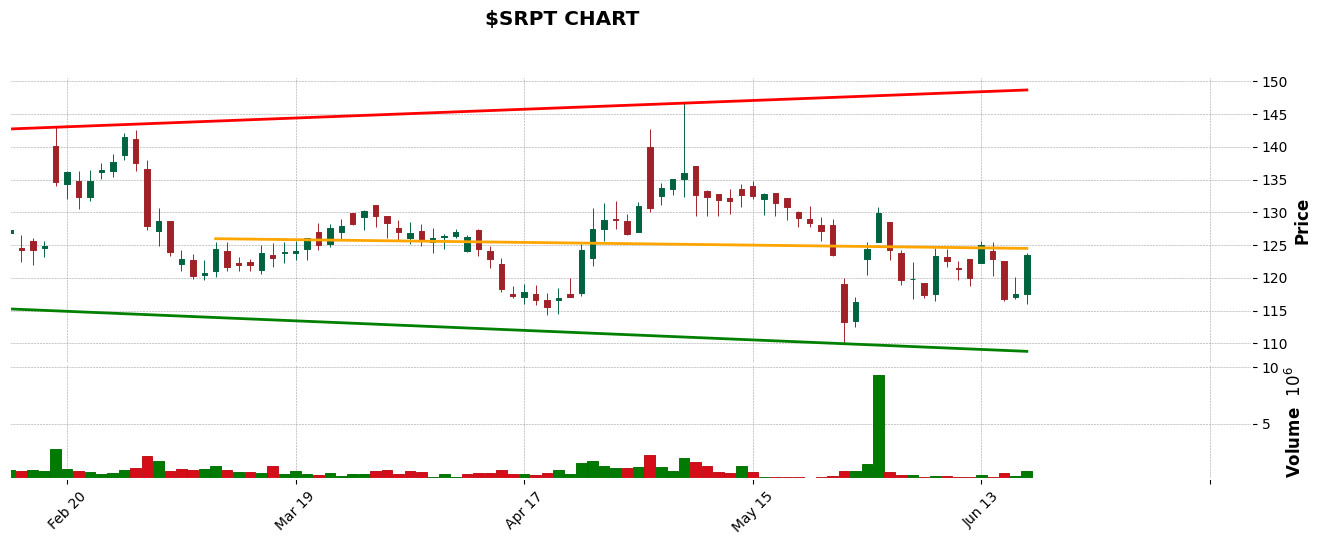

In [80]:
#### CHART IT ####
# Define the period for the x-axis view and future extension
lookback_periods = 90
future_periods = 20

# Calculate the extended index for the lookback period
lookback_index = ticker_df.index[-lookback_periods]

# Generate the future index by adding the future periods to the last date
future_index = pd.date_range(start=ticker_df.index[-1] + pd.Timedelta(days=1),
                             periods=future_periods, freq='B')

# Combine the current and future indices
full_index = ticker_df.index.union(future_index)

# Set the xlim for plotting
xlim = (lookback_index, full_index[-1])

# Plot the candlestick chart with extended x-axis
mpf.plot(ticker_df,
         type='candle',
         style='charles',
         volume=True,
         title=f'${ticker} CHART',
         figratio=(42, 14),
         xlim=xlim,  # Set the new x-axis limits
         addplot=apds)  # 'apds' should contain all your additional plots

In [81]:
ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-06-06,SRPT,117.44,119.22,116.94,119.20,282082
2024-06-07,SRPT,123.32,124.60,116.52,117.53,413050
2024-06-10,SRPT,122.59,124.34,121.69,123.13,363573
2024-06-11,SRPT,121.38,122.52,119.67,121.48,247048
2024-06-12,SRPT,119.98,122.93,118.74,122.93,271921
2024-06-13,SRPT,125.00,125.66,122.22,122.22,426185
2024-06-14,SRPT,122.84,125.52,120.34,124.09,281431
2024-06-17,SRPT,116.83,122.55,116.50,122.53,613564
2024-06-18,SRPT,117.52,120.15,116.79,117.01,399459


In [82]:
support_line

array([116.34184209, 116.26909389, 116.19634568, 116.12359748,
       116.05084927, 115.97810107, 115.90535286, 115.83260466,
       115.75985645, 115.68710824, 115.61436004, 115.54161183,
       115.46886363, 115.39611542, 115.32336722, 115.25061901,
       115.1778708 , 115.1051226 , 115.03237439, 114.95962619,
       114.88687798, 114.81412978, 114.74138157, 114.66863337,
       114.59588516, 114.52313695, 114.45038875, 114.37764054,
       114.30489234, 114.23214413, 114.15939593, 114.08664772,
       114.01389951, 113.94115131, 113.8684031 , 113.7956549 ,
       113.72290669, 113.65015849, 113.57741028, 113.50466208,
       113.43191387, 113.35916566, 113.28641746, 113.21366925,
       113.14092105, 113.06817284, 112.99542464, 112.92267643,
       112.84992822, 112.77718002, 112.70443181, 112.63168361,
       112.5589354 , 112.4861872 , 112.41343899, 112.34069079,
       112.26794258, 112.19519437, 112.12244617, 112.04969796,
       111.97694976, 111.90420155, 111.83145335, 111.75

# END ADVANCED WIP TESTS

| DATA PACKAGE |
|-|
| Trend Lines |


In [83]:
# # Step 3: Calculate the y-values for the line of best fit for the last 72 periods
# best_fit_last_72 = model.predict(X)

# # Create a series for the best fit line, filled with NaN except for the last 72 values
# best_fit_series = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # best_fit_series = pd.Series(model.predict(X), index=last_72_df.index)
# best_fit_series[-72:] = best_fit_last_72

# # # Step 4: Pivot Points
# # pivot_point_low_index = last_72_df['Close'].idxmin()
# # pivot_point_low_value = last_72_df.loc[pivot_point_low_index, 'Close']

# # pivot_point_high_index = last_72_df['Close'].idxmax()
# # pivot_point_high_value = last_72_df.loc[pivot_point_high_index, 'Close']

# # # Create a series for the pivot points, similar to the best fit line
# # pivot_points_low = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # pivot_points_low[pivot_point_low_index] = pivot_point_low_value

# # pivot_points_high = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # pivot_points_high[pivot_point_high_index] = pivot_point_high_value

# # # Step X: chart it
# # last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# # mpf.plot(ticker_df,
# #          type='candle',
# #          style='charles',
# #          volume=True,
# #          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
# #          figratio=(42, 14),
# #          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
# #          addplot=apds)

# # mpf.show()


# # # step 5: chart setup
# # apds = [
# #     mpf.make_addplot(best_fit_series, color='orange', width=2),
# #     mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
# #     mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
# # ]

# # # Step X: chart it
# # last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# # mpf.plot(ticker_df,
# #          type='candle',
# #          style='charles',
# #          volume=True,
# #          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
# #          figratio=(42, 14),
# #          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
# #          addplot=apds)

# # mpf.show()

In [84]:
# # step 5: chart setup
# apds = [
#     mpf.make_addplot(best_fit_series, color='orange', width=2),
#     mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
#     mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
# ]

In [85]:
# # Step X: chart it
# last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# mpf.plot(ticker_df,
#          type='candle',
#          style='charles',
#          volume=True,
#          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
#          figratio=(42, 14),
#          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
#          addplot=apds)

# mpf.show()


50DSMA - needed bc everyone has it
standard deviations (2 above)
63DMA - makes at least more sense (63 trading days in a quarter)
2dVWAP
3dVWAP
AVWAP

| Dataframe -> .csv file |
|-|

In [86]:
# # create a csv file with a flat date index (otherwise it'll get lost when saving to csv)
# ticker_csv_df = ticker_df.reset_index()
# # dtype of date
# print(ticker_csv_df['date'].dtype)
# # print index type
# print(ticker_csv_df.index.dtype)

# # save to csv
# ticker_csv_df.to_csv(f'{ticker}_historical_data{today_date_str}', index=False)

# ticker_csv_df.head(2)


In [87]:
# #### add VWAP to df
# chart_historical_df['VWAP'] = (chart_historical_df['volume'] * (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3).cumsum() / chart_historical_df['volume'].cumsum()

# chart_historical_df.head(4)

In [88]:
# """SIMPLE MOVING AVERAGES (SMA)"""
# def calculate_sma(dataframe, period):
#     return dataframe['close'].rolling(window=period).mean()

# chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
# chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
# chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

# chart_historical_df.tail(10)


In [89]:
# """EXPONENTIAL MOVING AVERAGES (EMA)"""
# def calculate_ema(dataframe, period):
#     return dataframe['close'].ewm(span=period, adjust=False).mean()

# # calculate EMAs for the specified periods
# chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
# chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
# chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
# chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

# chart_historical_df.tail(10)


In [90]:
# """MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# # calculate the MACD line and the Signal line
# chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
# chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# # MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
# chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

# chart_historical_df.tail(10)

In [91]:
# #### DEV - DATA ORGANIZATION ####
# chart_historical_df.columns

In [92]:
# """BOLLINGER BANDS (BB)"""
# # BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
# period = 20 # SMA periods
# std_dev_multiplier = 2 # standard deviation multiplier

# # line 1: middle band -> simple moving average (SMA)
# chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# # not a line: standard deviation -> used to calculate the upper and lower bands
# chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# # lines 2 & 3: upper and lower bands
# chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# # BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
# chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# # Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
# chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# # Calculate the standard deviation of the Typical Price
# chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# # Calculate the upper and lower bands for the Typical Price and name them accordingly
# chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# # view df with new (2) BBs (6 new columns)
# # chart_historical_df.iloc[-1] # last row slice to check the new columns
# chart_historical_df.tail(2)


In [93]:
# chart_historical_df.head(5)

In [94]:
# # drop rows that contain NAs (pulled extra data earlier for this purpose)
# chart_historical_df = chart_historical_df.dropna()

# # view the df
# chart_historical_df.head(5)

In [95]:
# # date column check data type
# chart_historical_df.index

In [96]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [97]:
# chart_historical_df.index

In [98]:
# chart_historical_df.head(5)

In [99]:
# print(tv_L2_df.columns)

In [100]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [101]:
# """RELATIVE STRENGTH INDEX (RSI)"""
# def calculate_rsi(dataframe, periods=14):
#     close_delta = dataframe['close'].diff()
#     up = close_delta.clip(lower=0)
#     down = -1 * close_delta.clip(upper=0)

#     ma_up = up.rolling(window=periods).mean()
#     ma_down = down.rolling(window=periods).mean()

#     rsi = ma_up / (ma_up + ma_down) * 100
#     return rsi

# # Adding the RSI to your DataFrame
# chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

# chart_historical_df.tail(10)


In [102]:
# """AVERAGE TRUE RANGE (ATR)"""
# def calculate_atr(dataframe, period=14):
#     high_low = dataframe['high'] - dataframe['low']
#     high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
#     low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

#     # Calculate the True Range (TR) as the maximum of the three measures
#     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

#     # Calculate the ATR by taking the rolling mean of the TR
#     atr = tr.rolling(window=period).mean()
    
#     return atr

# # Adding the ATR to your DataFrame
# chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

# chart_historical_df.tail(10)

In [103]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [104]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [105]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [106]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [107]:
# #### xlwings -> dynamic send to excel ####
# # save name for todays returend gap up stocks historical data
# chart_data_file = f'chart_data{today_date_str}.xlsx'

# # reset index before saving to Excel (need
# chart_historical_df.reset_index(inplace=True, drop=True)

# # Save the DataFrame to an Excel file
# chart_historical_df.to_excel(chart_data_file, index=False)

# # Use xlwings to open the file in Excel
# app = xw.App(visible=True)
# book = app.books.open(chart_data_file)

In [108]:
# # AVAILABLE COLS
# chart_historical_df.columns

In [109]:
# def plot_symbol_technicals(chart_historical_df, symbol):
#     # FILTER
#     symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    
#     # print(symbol_df.head(5))
#     # DATA PREP
#     add2plot = [
#         # mpf.make_addplot(symbol_df['SMA5'], color='#7BAFD4', width=1.0, label='SMA5'), 
#         # mpf.make_addplot(symbol_df['SMA10'], color='#003087', width=1.0, label='SMA10'), 
#         mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
#     ]
    
#     # STYLE & PLOT
#     mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
#     fig, axes = mpf.plot(symbol_df,
#                          type='candle',
#                          addplot=add2plot,
#                          volume=True,
#                          style=mpf_style,
#                         #  style='yahoo',
#                          figratio=(42, 12),
#                          title=f'${symbol} - Historical Data (4 Months)',
#                          tight_layout=True,
#                          returnfig=True)

#     # watermark
#     fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

#     mpf.show()


In [110]:
# # print a list of the unique stock symbols
# unique_symbols = chart_historical_df['symbol'].unique()
# print(f'Unique stock symbols: {unique_symbols}')

In [111]:
# #### EXECUTE CHARTING ####
# # DEV
# plot_symbol_technicals(chart_historical_df, 'GRND')

# # # PRO
# # for unique in unique_symbols:
# #     plot_symbol_technicals(chart_historical_df, unique)

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [112]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [113]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [114]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [115]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [116]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [117]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [118]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [119]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)